### This pyhton code is design to implement a prediction model for the number of casualties of an accident based on various human and natural traffic accident factors:
 ### Steps
#### 1: Data Pre precessing and Data Balancing
#### 2: Hyperparamaters Tuning
#### 3: Feature Selection
#### 4: Models' Performance Analysis 
#### 5: Models' Interpretation through the SHAP
#### 6: Models' Prediction Analysis through the Prediction Interval
    

In [2]:
# Basic libraries
import pandas as pd
import numpy as np 
from sklearn import preprocessing
import tracemalloc, time
import datetime
from datetime import timedelta

# Purposes: Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Purposes: Data Balancing
# We can install the imbalanced-learn with specific version and a compatibale scikit-learn version 
#!pip install imbalanced-learn==0.6.0
#!pip install scikit-learn==0.22.1
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Purposes: Peatures importance anaysis via permutation importance
from sklearn.inspection import permutation_importance

# Purposes: Data Scaling and Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Purposes: Evaluation Metrics for MSE and MAE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Purposes: Extreme Learning Machines (ELM), Linear Support Vectors Regression (LinearSVR) and Gradient Boosting Machine(GBoost)
# We have to install the scikit-elm package for the ELM Regressor 
#!pip install scikit-elm
from skelm import  ELMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR

# Purposes: Just to ignore warning messages
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
# Purpose: To split data into Train and Test set
from sklearn.model_selection import train_test_split

# Purposes: for the t-multipler calcualtion
from scipy.stats import norm
from scipy import stats

# Purposes: For the hyperparameter tuning for the ELM Aand GBoost regressors
from sklearn.model_selection import GridSearchCV

## 1. Data Preprocessing and Data Balancing

In [30]:
# Load the dataset to the memory
# The dataset was found from the kaggle url: https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables
accident=pd.read_csv('Accidents0514.csv', sep=",", engine='python')
casualty=pd.read_csv('Casualties0514.csv', sep=",",low_memory=False)
vehicle=pd.read_csv('Vehicles0514.csv', sep=",", low_memory=False)

In [31]:
# Some descriptions (total records and number of features per file)
print('Accidents', accident.shape)
print('Casualty', casualty.shape)
print('Vehicle', vehicle.shape)
print('Total Features', accident.shape[1]+casualty.shape[1]+vehicle.shape[1])

Accidents (1640597, 32)
Casualty (2216720, 15)
Vehicle (3004425, 22)
Total Features 69


In [32]:
# This function takes time in hh:mm and returns a transformed value in hour 0-23 
def hhmm2hh(time):
    if(pd.isnull(time)):
        time='00:00'
    h,m=time.split(":")
    h=int(h)
    m=int(m)
    if((m>=30) and (h!=23)):
        h=h+1
    elif((m>=30) and (h==23)):
        h=0
    else:
        h=h
    return h

In [33]:
# This function takes time in an hour (0-23) from the weekDays in a week and returns 0 or 1 based on the given criterion 
def timeFlagWeekDay(time):
    if(8 <= time <= 20):
        return 1
    else:
        return 0

In [34]:
# This function takes time in an hour (0-23) from the weekEnd in a week and returns 0 or 1 based on the given criterion 
def timeFlagWeekEnd(time):
    if(10 <= time <= 20):
        return 1
    else:
        return 0

In [35]:
# Transforms the Time feature from the accident file
accident['Time']=pd.to_numeric(accident['Time'].apply(hhmm2hh))

In [75]:
# The transformation from the Time to Time_Flag 
# In order to transform the Time feature we need to split the accident data into weekEnd and weekDay
accidentWeekEnd=accident[((accident['Day_of_Week']==1) | (accident['Day_of_Week']==7))]
accidentWeekDay=accident[~accident.isin(accidentWeekEnd)].dropna()
accidentWeekEnd=accident[~accident.isin(accidentWeekDay)].dropna()

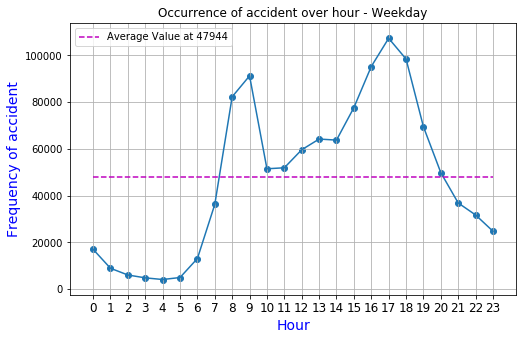

In [44]:
# Time with the WeekDay analysis 
%matplotlib inline
time=pd.DataFrame(accidentWeekDay.groupby(['Time']).count()['Number_of_Casualties']).reset_index()
y=[time['Number_of_Casualties'].mean() for i in range(0,24)]
av='Average Value at ' + str(int(time['Number_of_Casualties'].mean()))
plt.figure(figsize=(8,5))
plt.plot(time['Time'], time['Number_of_Casualties'])
plt.scatter(x=time['Time'], y=time['Number_of_Casualties'])
plt.plot(time['Time'], y, '--m', label=av)
plt.legend(loc='upper left')
plt.title('Occurrence of accident over hour - Weekday')
plt.xlabel('Hour',color='#0000ff', fontsize=14)
plt.ylabel('Frequency of accident', color='#0000ff',fontsize=14)
plt.xticks(range(0,24), fontsize=12)
plt.grid()
plt.show()

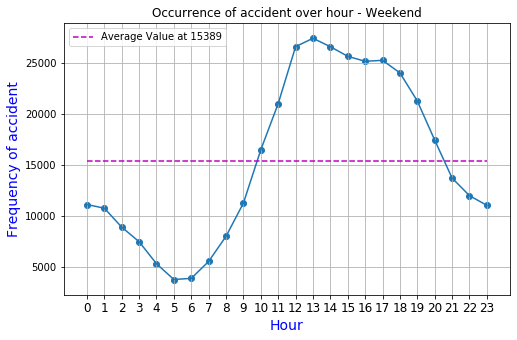

In [45]:
# Time with the WeekEnd analysis 
time=pd.DataFrame(accidentWeekEnd.groupby(['Time']).count()['Number_of_Casualties']).reset_index()
y=[time['Number_of_Casualties'].mean() for i in range(0,24)]
av='Average Value at ' + str(int(time['Number_of_Casualties'].mean()))
plt.figure(figsize=(8,5))
plt.plot(time['Time'], time['Number_of_Casualties'])
plt.scatter(x=time['Time'], y=time['Number_of_Casualties'])
plt.plot(time['Time'], y, '--m', label=av)
plt.legend(loc='upper left')
plt.title('Occurrence of accident over hour - Weekend')
plt.xlabel('Hour', color='#0000ff', fontsize=14)
plt.ylabel('Frequency of accident', color='#0000ff', fontsize=14)
plt.xticks(range(0,24), fontsize=12)
plt.grid()
plt.show()

In [46]:
# Creates a feature TimeFlag and links a transformed values 
accidentWeekEnd['TimeFlag']=accidentWeekEnd['Time'].apply(timeFlagWeekEnd)

In [47]:
# Similarly, for the weekDay Creates a feature TimeFlag and links a transformed values
accidentWeekDay['TimeFlag']=pd.to_numeric(accidentWeekDay['Time'].apply(timeFlagWeekDay))

In [56]:
# Combines the weekDay and weekEnd records 
mrg=[accidentWeekEnd, accidentWeekDay]
dataAccident=pd.concat(mrg)
dataAccident.rename(columns = {"ï»¿Accident_Index": "Accident_Index"}, inplace=True)
dataAccident

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,TimeFlag
8,200501BS00010,527350.0,177650.0,-0.167342,51.483420,1.0,3.0,2.0,2.0,15/01/2005,...,5.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002900,0
9,200501BS00011,524550.0,180810.0,-0.206531,51.512443,1.0,3.0,2.0,5.0,15/01/2005,...,8.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002875,1
10,200501BS00012,526240.0,178900.0,-0.182872,51.494902,1.0,3.0,1.0,1.0,16/01/2005,...,5.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002835,0
19,200501BS00022,526790.0,178980.0,-0.174925,51.495498,1.0,2.0,1.0,1.0,08/01/2005,...,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002821,0
24,200501BS00029,527380.0,179280.0,-0.166322,51.498062,1.0,3.0,2.0,1.0,29/01/2005,...,5.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,E01002819,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631798,201463DP39614,306110.0,262480.0,-3.376854,52.252424,63.0,3.0,2.0,1.0,11/11/2014,...,0.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,W01000455,1
1631799,201463DP39714,306900.0,292370.0,-3.373600,52.521201,63.0,3.0,1.0,2.0,29/12/2014,...,0.0,7.0,1.0,4.0,0.0,0.0,2.0,2.0,W01000488,0
1631800,201463DP39814,324470.0,308900.0,-3.118481,52.672499,63.0,3.0,3.0,2.0,03/11/2014,...,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,W01000500,1
1631802,201463DP40014,303060.0,290240.0,-3.429555,52.501388,63.0,2.0,3.0,4.0,02/12/2014,...,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,W01000453,1


In [57]:
# Possible input features for the prediction of the number of casualties are 28 and one response feature (number of casualties) 
# These all 28 +1 features are from the accident and vehicle data.
AccidentCols=['Accident_Index','Number_of_Casualties', 'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Detail',
              'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control',
              'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions','Road_Surface_Conditions', 
              'Special_Conditions_at_Site', 'Carriageway_Hazards','Urban_or_Rural_Area', 'TimeFlag']

VehicleCols=['Accident_Index', 'Vehicle_Type', 'Towing_and_Articulation','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane',
             'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 
             'Hit_Object_off_Carriageway','Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver', 
             'Propulsion_Code']

In [59]:
# Merges the selected features
# The Accident_Index was a connector and we do not need it further
data=pd.merge(vehicle[VehicleCols], dataAccident[AccidentCols], on='Accident_Index', how='left').dropna()
data=data.drop_duplicates('Accident_Index')
data=data.drop(['Accident_Index'],axis=1)
data=data.astype(int)
data

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,...,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,TimeFlag
0,9,0,18,0,0,0,0,0,0,15,...,-1,0,1,1,2,2,0,0,1,1
1,11,0,4,0,3,0,0,0,0,1,...,5,0,5,4,1,1,0,0,1,1
2,11,0,17,0,0,0,4,0,0,1,...,-1,0,0,4,1,1,0,0,1,0
4,9,0,18,0,0,0,0,0,0,15,...,-1,0,0,1,1,1,0,0,1,1
5,3,0,18,0,0,1,10,0,0,15,...,-1,0,0,7,1,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2989209,9,0,16,0,0,0,6,0,0,6,...,-1,0,0,6,2,2,0,0,2,0
2989210,9,0,18,0,0,2,0,7,0,6,...,-1,0,0,6,1,1,0,0,2,1
2989211,9,0,13,0,0,0,0,0,0,6,...,-1,0,0,6,2,2,0,0,2,1
2989213,9,0,18,0,4,0,0,0,0,6,...,3,0,0,4,9,2,0,0,2,1


In [60]:
# Distributions of the data based on unique response values of the response feature (Number_of_Casualties)
distribution=data.sort_values(by ='Number_of_Casualties', ascending=True, ignore_index=True)
distribution=data.groupby('Number_of_Casualties')['Number_of_Casualties'].count().reset_index(
    name='counts').sort_values(by ='counts', ascending=False, ignore_index=True)
distribution

,Number_of_Casualties,counts
0,1,1162690
1,2,246065
2,3,70352
3,4,25491
4,5,9412
5,6,3543
6,7,1215
7,8,511
8,9,251
9,10,135


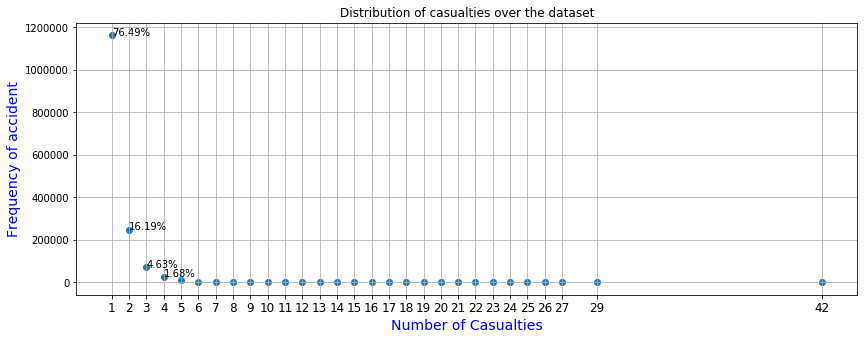

In [63]:
# Based on the above distribution query result, we have 48 unique response values
# The data is not balanced, we should apply the data balancing technique to get better results
# 1. Thus, to balance the data, each response value should have at least three observations.
# 2. And each observation should be meaningful to represent it. but -1 is missing information. so we removed observation which 
     # contains -1 (missing value)

# Based on the criteria-1 mentioned we will have the following list
arr=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,26,19,29,22, 23,24, 42, 25, 20,27]

#Filtering
lists = distribution[distribution['Number_of_Casualties'].isin(arr)].sort_values(by ='Number_of_Casualties', ascending=True, ignore_index=True)

#Daata label
label=[]
total=sum(list(lists['counts']))
for i, j in lists.iterrows():
    value=round((j[1]/total)*100, 2)
    if(value<1):
        label.append("")
    else:
        label.append(str(value)+ "%")

#Distributions of the data 
plt.figure(figsize=(14,5))
#fig, ax = plt.subplots()
#plt.plot(time['Time'], time['counts'])
plt.scatter(x=lists['Number_of_Casualties'], y=lists['counts'])
#plt.plot(lists['Number_of_Casualties'], lists['counts'], '--m', label="xx")
#plt.legend(loc='best')
plt.title('Distribution of casualties over the dataset')
plt.xlabel('Number of Casualties', color='#0000ff', fontsize=14)
plt.ylabel('Frequency of accident', color='#0000ff', fontsize=14)

for i, txt in enumerate(label):
    plt.annotate(txt, (lists['Number_of_Casualties'][i], lists['counts'][i]))
plt.xticks(arr, fontsize=12)
plt.grid()
plt.show()
xy =data[(data != -1).all(axis=1)]

In [64]:
# If we applied the removal of missing values before data balancing, we may loss observations from majority response values
# Thus we applied removal of missing values first before downsampling (subsets) technique

# The response values 1 and 2 are considered as majority classes
# Filter majority classes
newDataData=data[(data != -1).all(axis=1) & (data['Number_of_Casualties']==1) | (data['Number_of_Casualties']==2)]

#Remove missing values
major=newDataData[(newDataData != -1).all(axis=1)]

#Minority Classses
minor=data[(data['Number_of_Casualties']!=1) & (data['Number_of_Casualties']!=2)]

#Combine the files(minorty and majority)
newDataData2=pd.concat([major, minor], axis=0)
newDataData2

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,...,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,TimeFlag
1,11,0,4,0,3,0,0,0,0,1,...,5,0,5,4,1,1,0,0,1,1
11,9,0,18,0,8,0,0,0,0,15,...,4,0,5,4,1,1,0,0,1,0
15,9,0,18,0,8,0,0,0,0,15,...,4,0,5,4,1,1,0,0,1,0
16,9,0,9,0,8,0,0,0,0,15,...,3,0,5,4,1,2,0,0,1,0
18,9,0,9,0,3,0,0,0,0,15,...,3,0,1,1,2,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2989140,10,0,13,0,1,2,0,7,10,1,...,6,0,0,1,1,1,0,0,2,1
2989146,9,0,16,0,0,0,0,0,0,6,...,-1,0,0,6,1,2,0,0,2,1
2989165,9,0,17,0,8,2,10,1,7,6,...,6,0,0,6,9,1,0,0,2,1
2989206,9,0,13,0,0,1,0,7,0,6,...,-1,0,0,1,1,1,0,0,2,1


In [66]:
# Data Balancing

# number of neighbours for minority classes
k = 2

# We have possible classes each has at least 3 observations (that why we applied k=3)
arr=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,26,19,29,22, 23,24, 42, 25, 20,27]

major=[1,2] # seems majority classes
minor=[x for x in arr if x not in (major)] # Minority classes

#Each class will have the same number of observations 
strategyMinor=dict((k,100000) for k in minor) # Minority
strategyMajor=dict((k,100000) for k in major) # Majority

# Splits the data into the predictors and response values
X = newDataData2.loc[:, newDataData2.columns != 'Number_of_Casualties']
y = newDataData2.Number_of_Casualties

# Apply Oversampling using SMOTE and downsampling
over = SMOTE(sampling_strategy=strategyMinor, k_neighbors=k)
under = RandomUnderSampler(sampling_strategy=strategyMajor)

# Feed to the pipline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Transform the data
X, y = pipeline.fit_resample(X, y)

In [67]:
# Merge the predictors and response values into dataset 
dataset=pd.concat([X, y], axis=1)

# Just to remember the dataset is with the selected Number of Casualties
dataset=dataset[dataset['Number_of_Casualties'].isin(arr)]
dataset

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,TimeFlag,Number_of_Casualties
0,9,0,18,0,1,0,0,0,0,15,...,0,0,1,1,2,0,0,1,1,1
1,9,0,3,0,4,0,0,0,0,15,...,0,0,1,1,1,0,0,1,1,1
2,9,0,9,0,1,0,0,0,0,6,...,0,0,1,1,1,0,0,1,1,1
3,9,0,18,0,8,0,0,0,0,15,...,0,1,1,1,1,0,0,1,1,1
4,9,0,4,0,1,0,0,0,0,15,...,0,5,1,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2900003,11,0,4,0,0,0,0,0,0,1,...,0,0,1,7,2,0,0,2,0,42
2900004,11,0,15,0,0,4,0,1,0,1,...,0,0,1,1,1,0,0,2,0,42
2900005,11,0,18,0,0,1,0,0,0,1,...,0,0,1,4,1,0,0,2,0,42
2900006,11,0,2,0,0,0,0,0,0,1,...,0,0,1,6,1,0,0,2,0,42


In [68]:
# Now apply the removal of missing values for the minority classes 
# Of course, we can apply to the entire dataset because observations from the majority side is already cleared
dataset=dataset[(dataset != -1).all(axis=1)]
dataset

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,TimeFlag,Number_of_Casualties
0,9,0,18,0,1,0,0,0,0,15,...,0,0,1,1,2,0,0,1,1,1
1,9,0,3,0,4,0,0,0,0,15,...,0,0,1,1,1,0,0,1,1,1
2,9,0,9,0,1,0,0,0,0,6,...,0,0,1,1,1,0,0,1,1,1
3,9,0,18,0,8,0,0,0,0,15,...,0,1,1,1,1,0,0,1,1,1
4,9,0,4,0,1,0,0,0,0,15,...,0,5,1,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799992,10,0,17,0,7,0,0,0,0,2,...,0,4,1,1,1,0,0,1,1,29
2799994,10,0,18,0,1,0,3,0,3,1,...,0,0,1,1,1,0,0,1,1,29
2799996,10,0,11,0,1,0,0,4,2,1,...,0,0,1,1,1,0,0,2,1,29
2799998,10,0,9,0,1,0,0,6,4,1,...,0,0,1,1,1,0,0,1,1,29


In [70]:
# Let us check observations per response value after removing missing values
distribution=dataset.groupby('Number_of_Casualties')['Number_of_Casualties'].count().reset_index(
    name='counts').sort_values(by ='counts', ascending=False, ignore_index=True)
distribution

,Number_of_Casualties,counts
0,1,100000
1,2,100000
2,24,99998
3,18,99996
4,23,74905
5,27,66585
6,16,49965
7,22,49883
8,9,49002
9,11,46786


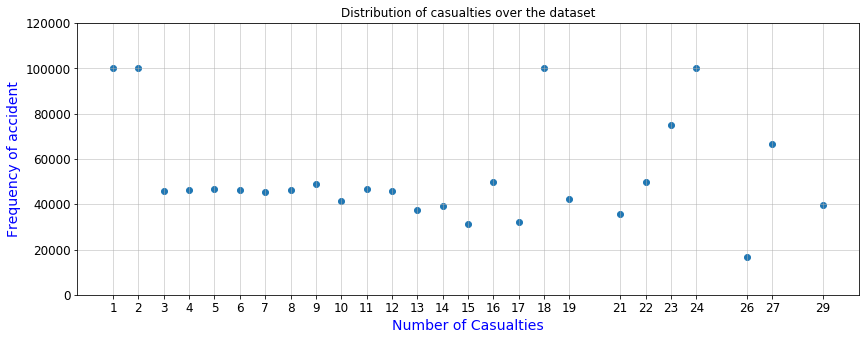

In [71]:
# Visualizes the distributions
arr=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,19,29,22, 23,24,  27, 26]
listsAfter=dataset.groupby('Number_of_Casualties')['Number_of_Casualties'].count().reset_index(
    name='counts').sort_values(by ='counts', ascending=False, ignore_index=True)
plt.figure(figsize=(14,5))
#fig, ax = plt.subplots()
#plt.plot(time['Time'], time['counts'])
plt.scatter(x=listsAfter['Number_of_Casualties'], y=listsAfter['counts'])
#plt.plot(lists['Number_of_Casualties'], lists['counts'], '--m', label="xx")
#plt.legend(loc='best')
plt.title('Distribution of casualties over the dataset')
plt.xlabel('Number of Casualties', color='#0000ff', fontsize=14)
plt.ylabel('Frequency of accident', color='#0000ff', fontsize=14)

#for i, txt in enumerate(label):
#    plt.annotate(txt, (lists['Number_of_Casualties'][i], lists['counts'][i]))
plt.xticks(arr, fontsize=12)
plt.yticks(range(0, 130000, 20000), fontsize=12)
plt.grid(alpha=0.6)
plt.show()

In [ ]:
# We can save the processed data to local drive
dataset.to_csv ('Processed_Data.csv', index = False, header=True)

In [ ]:
# Then also read from the local drive
newData=pd.read_csv('Processed_Data.csv', sep=",")

In [117]:
# Sample data from the dataset
sampleData=sampling(newData, 70000)
sampleData

,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,TimeFlag,Number_of_Casualties
0,9,0,9,0,6,0,0,0,0,15,...,0,0,4,1,1,0,0,1,1,1
1,9,0,17,0,1,2,6,1,7,6,...,0,0,4,4,2,0,0,1,0,1
2,9,0,18,0,1,1,0,1,0,2,...,0,0,6,2,2,0,0,2,0,1
3,9,0,18,0,8,1,0,0,0,6,...,0,0,1,1,1,0,0,1,1,1
4,19,0,18,0,8,5,0,1,9,1,...,0,0,1,5,5,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,15,0,17,0,4,0,1,0,0,2,...,0,2,1,1,1,0,0,1,1,29
69983,10,0,18,0,5,0,1,0,1,2,...,0,3,1,1,1,0,0,1,1,29
69984,10,0,18,0,6,0,0,0,0,2,...,0,4,1,1,1,0,0,1,1,29
69985,11,0,17,0,7,0,0,0,0,2,...,0,4,1,1,1,0,0,1,1,29


## 2: Hyperparamaters Tuning

In [ ]:
#Dataset split: fit and test
X_data = sampleData.loc[:, sampleData.columns.isin(SelectedList)]
y_data = sampleData.Number_of_Casualties
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

In [119]:
#Hyperparameters Tuning- GBoost
num_estimators = [50, 100,500, 1000, 1500]
learn_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
loss=['ls', 'lad', 'huber','quantile']
criterion=['friedman_mse', 'mse', 'mae']
params = {   'learning_rate': learn_rates,
              'loss':loss,
              'criterion':criterion}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=0), params, cv=3, return_train_score=True)
grid_search.fit(X_data, y_data)

In [120]:
#Obtained the followings-GBoost
#best_params_={'num_estimators': 1500, 'criterion': 'mse', 'learning_rate': 0.3, 'loss': 'huber'}

In [ ]:
#Hyperparameters Tuning- ELM 
n_neurons = [(100, 50), (200, 100), (200, 200), (300, 200), (300, 300), (400, 300), (400, 400), (500, 400),(500, 500)]
ufunc = ['sigm', 'relu', 'tanh', 'lin']
pairwise_metric=['cosine', 'euclidean', 'cityblock' ]
params = {   'n_neurons': n_neurons,
              'ufunc':ufunc,
              'pairwise_metric':pairwise_metric}

grid_search = GridSearchCV(ELMRegressor(), params, cv=3, return_train_score=True)
grid_search.fit(X_data, y_data)
n_neurons=(300, 300),ufunc=('tanh', None),density=(None, None),pairwise_metric=(None, 'euclidean')

In [ ]:
#Obtained the followings-ELM
#best_params_={'n_neurons': (300, 300), 'ufunc': 'tanh', 'pairwise_metric': euclidean'}

## 3: Feature Selection


In [72]:
# Sampling technique if needed= to select the same number of observations from each class 
def sampling(data, size):
    #We can make the sample_size a function of group size to sample 
    # with equal probabilities (or proportionately):

    nrows = len(data)
    data1=data.groupby(['Number_of_Casualties'], as_index=False).apply(lambda
                                        x: x.sample(int((x.Number_of_Casualties.count()/nrows)*size)))
    data1=data1.reset_index()
    data1=data1.drop(['level_0', 'level_1'],axis=1)
    return data1

In [73]:
# Features Ranking based on their importance score
def importance(model, data):
    # Predictors and response features
    X_data = data.loc[:, data.columns != 'Number_of_Casualties']
    y_data = data.Number_of_Casualties
    
    # define the model
    scaler = StandardScaler().fit(X_data)
    X_datax = scaler.transform(X_data)
    model.fit(X_datax, y_data)
    perm = PermutationImportance(model, random_state=1, scoring='neg_mean_squared_error').fit(X_datax, y_data)
    
    # Summary using the Boxplot
    # figure size in inches
    rcParams['figure.figsize'] = 16,6

    results = pd.DataFrame(data=perm.results_, columns=X_data.columns)
    (sns.boxplot(data=results).set(title='Importance Distributions with #'+ str(len(data)) +' observations'))
    plt.xlabel('Feature', color='#0000ff',fontsize=14)
    plt.ylabel('Importance Score', color='#0000ff', fontsize=14)
    plt.xticks(range(0, len(pd.Series(X_data.columns))), pd.Series(X_data.columns), rotation=90, fontsize=12)
    plt.show()
    
    # Summary using Average Importance score
    d=eli5.explain_weights_df(perm, feature_names=X_data.columns.tolist())
    plt.figure(figsize=(16,6))
    plt.bar(range(0, len(d.feature)), d.weight,align='center')
    plt.title("Average Importance")
    plt.xlabel('Feature', color='#0000ff', fontsize=14)
    plt.ylabel('Importance Score', color='#0000ff', fontsize=14)
    plt.xticks(range(0, len(d.feature)), d.feature, rotation=90, fontsize=12)
    plt.show()
    return d

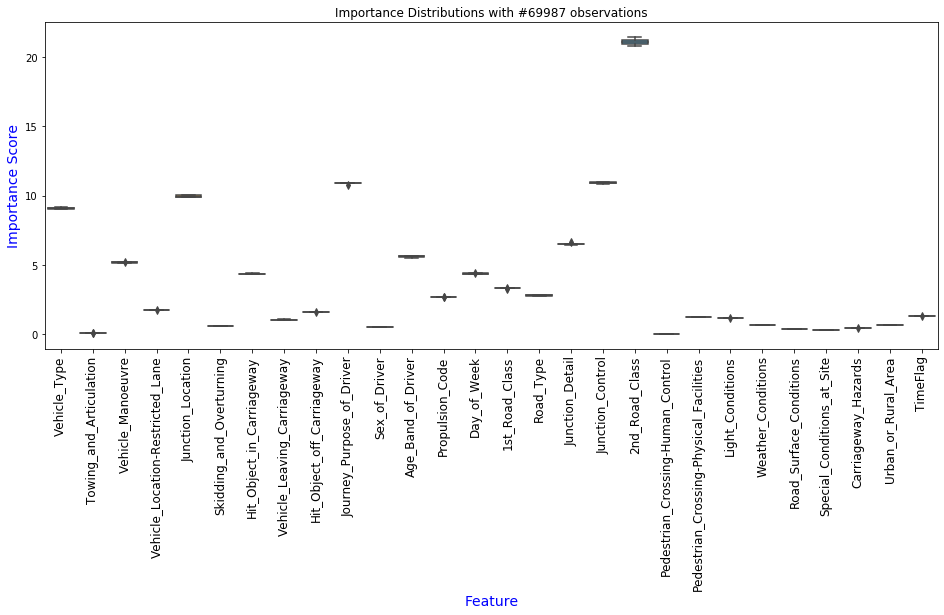

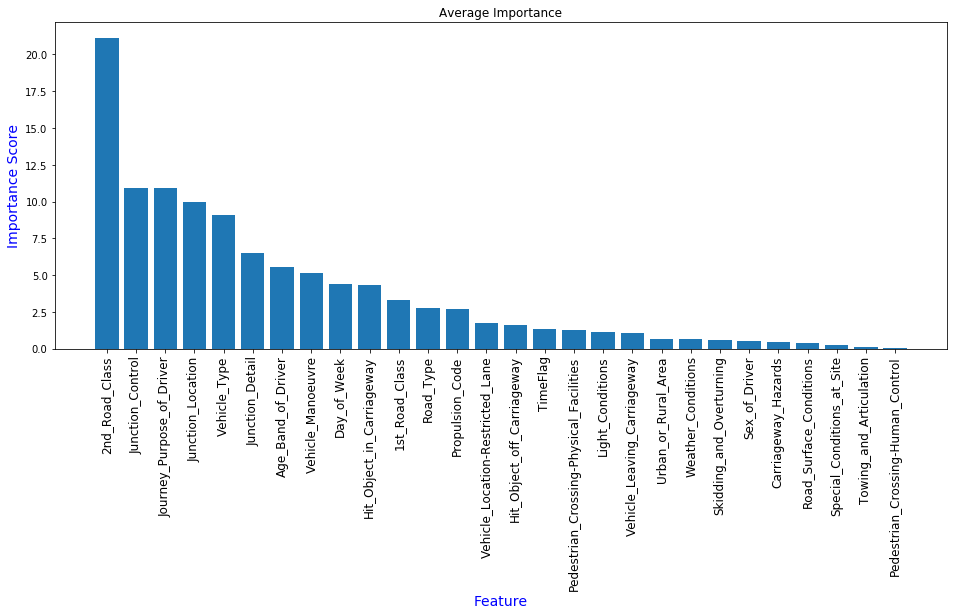

In [121]:
gboost=importance(GradientBoostingRegressor(random_state=0,loss ="ls",learning_rate=0.6, criterion="friedman_mse", alpha=0.5, 
                                  n_estimators=1000), sampleData)

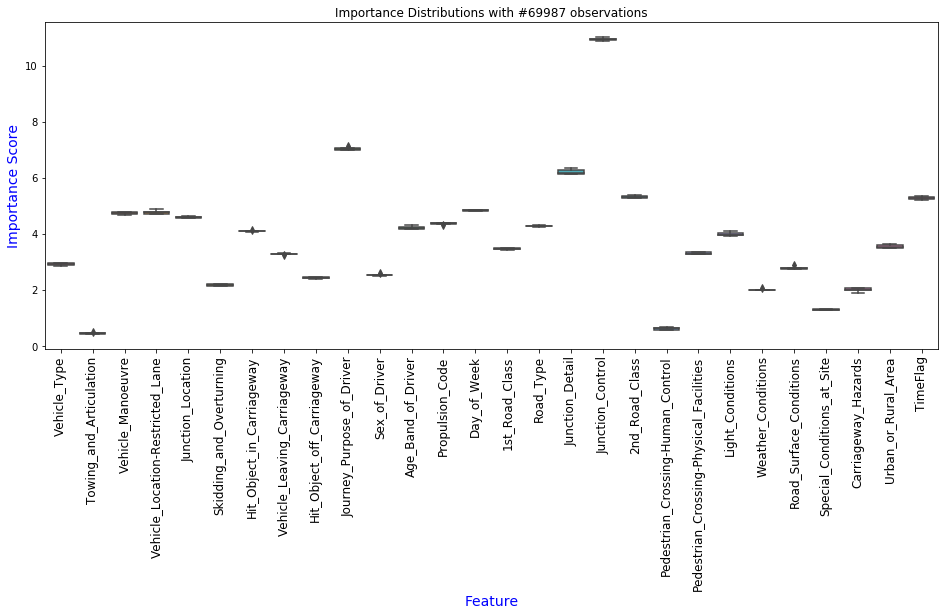

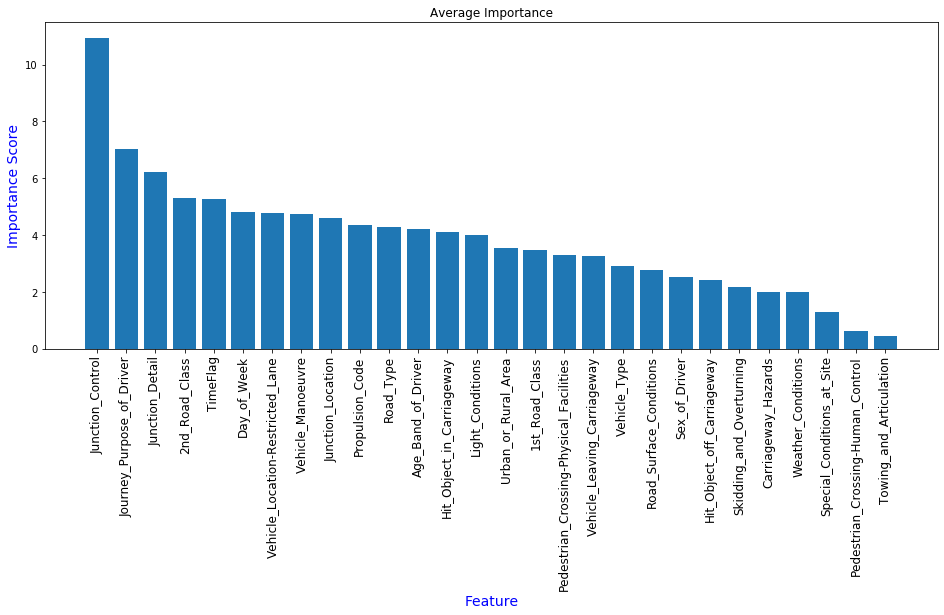

In [129]:
elm=importance(ELMRegressor(n_neurons=(300, 300),ufunc=('tanh', None),density=(None, None),
                           pairwise_metric=(None, 'euclidean')),sampleData)

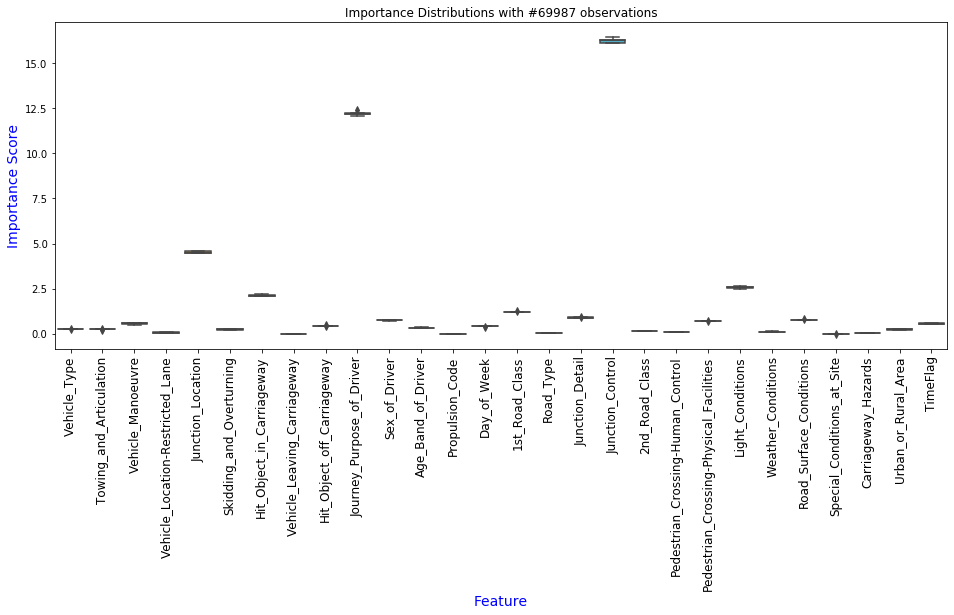

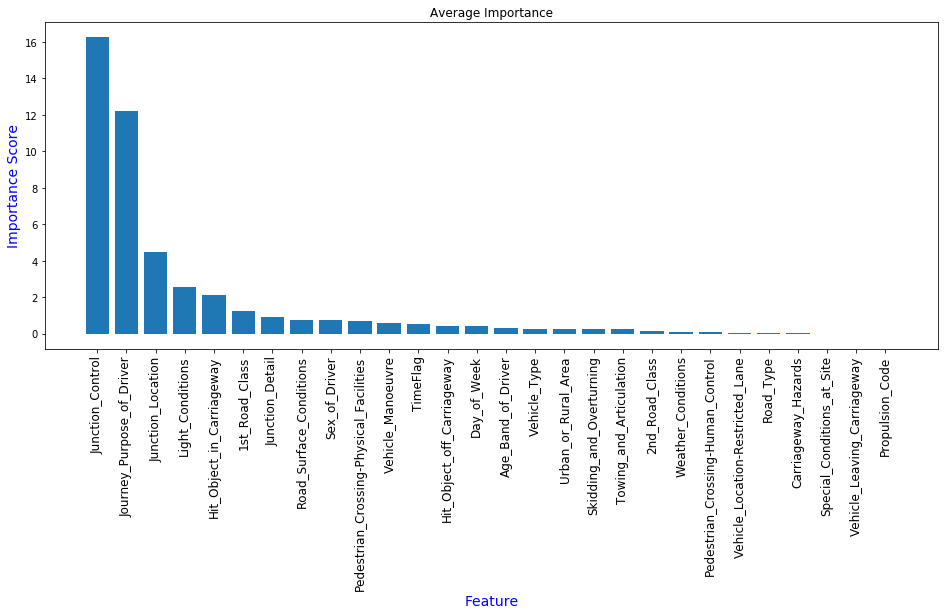

In [130]:
svr=importance(LinearSVR(random_state=0,C=1.0,dual=True,epsilon=0.1,loss="epsilon_insensitive",tol=0.01), sampleData)

In [131]:
# Calculate the average
ELM=elm.sort_values(by=['feature'])
GBoost=gboost.sort_values(by=['feature'])
SVR=svr.sort_values(by=['feature'])
AVG=pd.concat([ELM, GBoost, SVR], axis=0)
AVG=AVG.groupby('feature').agg({'weight': 'mean'}).reset_index()

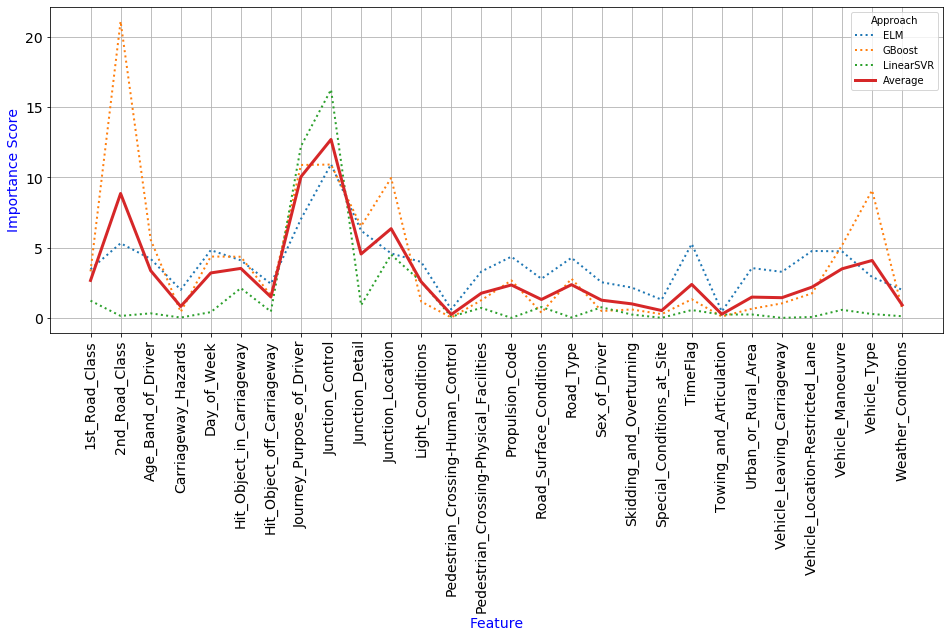

In [140]:
# Visualizations
rcParams['figure.figsize'] = 16,6
plt.plot(range(0,len(ELM.weight)), ELM.weight, linestyle = 'dotted',linewidth=2, label="ELM")
plt.plot(range(0,len(GBoost.weight)), GBoost.weight, linestyle = 'dotted',linewidth=2, label="GBoost")
plt.plot(range(0,len(SVR.weight)), SVR.weight, linestyle = 'dotted',linewidth=2, label="LinearSVR")
plt.plot(range(0,len(AVG.weight)), AVG.weight, linestyle = 'solid', linewidth=3, label="Average")
plt.xlabel('Feature', color='#0000ff', fontsize=14)
plt.ylabel('Importance Score', color='#0000ff', fontsize=14)
plt.xticks(range(0, len(pd.Series(ELM.feature))), pd.Series(ELM.feature), rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title="Approach")
plt.grid()
plt.show()

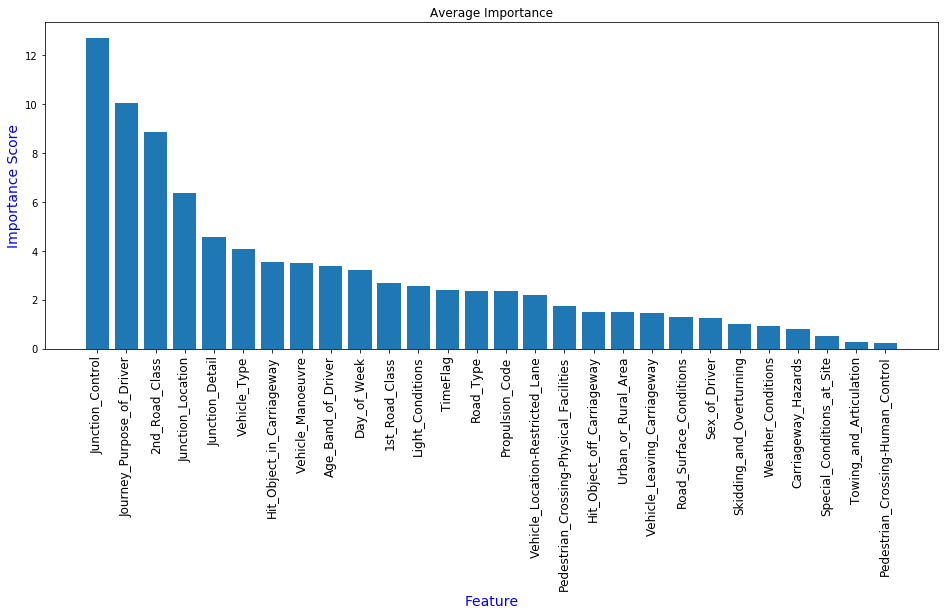

In [133]:
importanceRank=AVG.sort_values(by=['weight'], ascending=False)
# figure size in inches
rcParams['figure.figsize'] = 16,6
plt.bar(range(0, len(importanceRank.feature)), importanceRank.weight,align='center')
plt.title("Average Importance")
plt.xlabel('Feature', color='#0000ff', fontsize=14)
plt.ylabel('Importance Score', color='#0000ff', fontsize=14)
plt.xticks(range(0, len(importanceRank.feature)), importanceRank.feature, rotation=90, fontsize=12)
plt.show()

In [134]:
#Rank Evaluation 
def analysis(model, dt, feature):
    currentFeature=[]
    size=[]
    rmse=[]
    mae=[]
    y_data = dt.Number_of_Casualties
    for i in range(0, len(feature)):
        currentFeature.append(feature[i])
        X_data = dt.loc[:, dt.columns.isin(currentFeature)]
        model.fit(X_data, y_data)
        predicted=model.predict(X_data)
        RMSE=mean_squared_error(y_data, predicted, squared=False)
        rmse.append(RMSE)
        MAE=mean_absolute_error(y_data, predicted)
        mae.append(MAE)
        size.append(len(dt))
    result=pd.concat([pd.DataFrame(size), pd.DataFrame(rmse), pd.DataFrame(mae)], axis=1)
    currentFeature1=[]
    rmse1=[]
    mae1=[]
    for i in range(0, len(feature)):
        currentFeature1.append(feature[i])
        X_data = dt.loc[:, dt.columns.isin(currentFeature1)]
        scaler = MinMaxScaler().fit(X_data)
        X_datax = scaler.transform(X_data)
        model.fit(X_datax, y_data)
        predicted=model.predict(X_datax)
        RMSE=mean_squared_error(y_data, predicted, squared=False)
        rmse1.append(RMSE)
        MAE=mean_absolute_error(y_data, predicted)
        mae1.append(MAE)
        size.append(len(dt))
    result=pd.concat([result, pd.DataFrame(rmse1), pd.DataFrame(mae1)] ,axis=1)
    currentFeature2=[]
    rmse2=[]
    mae2=[]
    for i in range(0, len(feature)):
        currentFeature2.append(feature[i])
        X_data = dt.loc[:, dt.columns.isin(currentFeature2)]
        scaler = StandardScaler().fit(X_data)
        X_datax = scaler.transform(X_data)
        model.fit(X_datax, y_data)
        predicted=model.predict(X_datax)
        RMSE=mean_squared_error(y_data, predicted, squared=False)
        rmse2.append(RMSE)
        MAE=mean_absolute_error(y_data, predicted)
        mae2.append(MAE)
        size.append(len(dt))
    result=pd.concat([result, pd.DataFrame(rmse2), pd.DataFrame(mae2)] ,axis=1)
    return result

In [135]:
elmr=analysis(ELMRegressor(n_neurons=(300, 300),ufunc=('tanh', None),density=(None, None),
                           pairwise_metric=(None, 'euclidean')),sampleData, list(importanceRank['feature']))
elmr.columns=['Size','ActualRMSE','ActualMAE', "NormRMSE", "NormMAE",'ScalRMSE', 'ScalMAE']
elmr

,Size,ActualRMSE,ActualMAE,NormRMSE,NormMAE,ScalRMSE,ScalMAE
0,69987,6.844789,5.758183,6.844789,5.758183,6.844789,5.758183
1,69987,5.723493,4.604175,5.697589,4.570374,5.688750,4.558973
2,69987,5.252351,4.079935,5.296359,4.139242,5.131083,3.946534
3,69987,4.562766,3.421120,4.769049,3.655273,4.615960,3.499079
4,69987,4.178444,3.051983,4.474523,3.402203,4.292983,3.194883
5,69987,4.152874,3.135490,4.393512,3.347689,4.138719,3.122069
6,69987,3.937797,2.953719,4.253610,3.260393,3.914660,2.937225
7,69987,3.983699,3.001313,4.116524,3.160857,3.767653,2.851535
8,69987,3.669805,2.763648,3.896023,2.950975,3.534202,2.647281
9,69987,3.536960,2.650340,3.698574,2.773503,3.406601,2.540673


In [94]:
gboostr=analysis(GradientBoostingRegressor(random_state=0,loss ="ls",learning_rate=0.6, criterion="friedman_mse", alpha=0.5, 
                                  n_estimators=1000), 
        sampleData, list(importanceRank['feature']))
gboostr.columns=['Size','ActualRMSE','ActualMAE', "NormRMSE", "NormMAE",'ScalRMSE', 'ScalMAE']
gboostr

,Size,ActualRMSE,ActualMAE,NormRMSE,NormMAE,ScalRMSE,ScalMAE
0,70000,6.874683,5.799929,6.874683,5.799929,6.874683,5.799929
1,70000,6.398885,5.256863,6.398885,5.256863,6.398885,5.256863
2,70000,5.122089,3.947710,5.122089,3.947710,5.122089,3.947710
3,70000,4.351131,3.207783,4.351131,3.207783,4.351131,3.207783
4,70000,3.845686,2.710565,3.845686,2.710565,3.845686,2.710565
5,70000,3.263550,2.248185,3.263550,2.248185,3.263550,2.248185
6,70000,2.928550,1.979540,2.928550,1.979540,2.928550,1.979540
7,70000,2.503596,1.699306,2.503596,1.699306,2.503596,1.699306
8,70000,2.194858,1.450233,2.194858,1.450233,2.194858,1.450233
9,70000,2.005598,1.325695,2.005598,1.325695,2.005598,1.325695


In [113]:
svrr=analysis(LinearSVR(random_state=0,C=1.0,dual=True,epsilon=0.1,loss="epsilon_insensitive",tol=0.01), 
              sampleData, list(importanceRank['feature']))
svrr.columns=['Size','ActualRMSE','ActualMAE', "NormRMSE", "NormMAE",'ScalRMSE', 'ScalMAE']
svrr

,Size,ActualRMSE,ActualMAE,NormRMSE,NormMAE,ScalRMSE,ScalMAE
0,60000,7.183436,5.968828,7.284051,5.934227,7.383668,5.951754
1,60000,7.171529,5.858525,7.146380,5.862229,7.158915,5.861989
2,60000,6.536237,5.308962,6.455654,5.281283,6.482307,5.288365
3,60000,6.246956,5.128658,6.222190,5.116534,6.233411,5.144288
4,60000,6.249406,5.133698,6.254646,5.138256,6.198290,5.112431
5,60000,6.190695,5.098892,6.184340,5.095176,6.212412,5.099445
6,60000,6.214235,5.014633,6.238668,5.016210,6.235292,5.020380
7,60000,6.171981,4.980666,6.238191,4.998194,6.218269,4.987486
8,60000,6.270978,4.986758,6.216479,4.959261,6.212823,4.974827
9,60000,6.254723,4.977505,6.189284,4.955386,6.176843,4.955557


In [136]:
AVGR=pd.concat([elmr, gboostr, svrr], axis=0)

In [137]:
AVGRR=AVGR.groupby(AVGR.index).agg({'ActualRMSE': 'mean', 'ActualMAE': 'mean', 'NormRMSE': 'mean', 'NormMAE': 'mean', 
                                  'ScalRMSE': 'mean', 'ScalMAE': 'mean'})

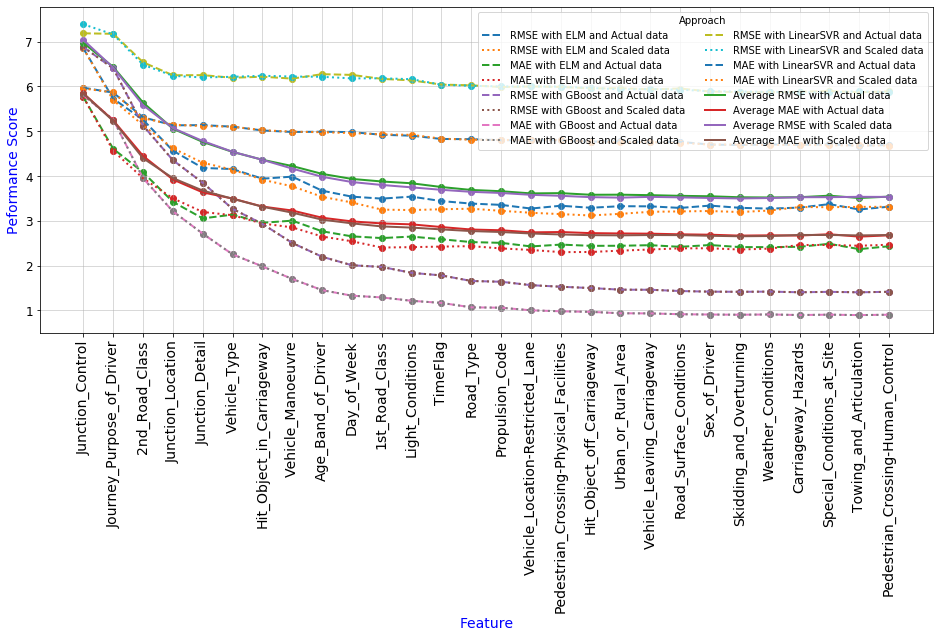

In [139]:
# figure size in inches
rcParams['figure.figsize'] = 16,6
plt.plot(range(0,len(elmr.ActualRMSE)),elmr.ActualRMSE, linestyle = 'dashed',linewidth=2,
         label="RMSE with ELM and Actual data")
plt.scatter(range(0,len(elmr.ActualRMSE)), elmr.ActualRMSE)
plt.plot(range(0,len(elmr.ScalRMSE)), elmr.ScalRMSE, linestyle = 'dotted',linewidth=2, 
         label="RMSE with ELM and Scaled data")
plt.scatter(range(0,len(elmr.ScalRMSE)), elmr.ScalRMSE)
plt.plot(range(0,len(elmr.ActualMAE)),elmr.ActualMAE, linestyle = 'dashed',linewidth=2,
         label="MAE with ELM and Actual data")
plt.scatter(range(0,len(elmr.ActualMAE)), elmr.ActualMAE)
plt.plot(range(0,len(elmr.ScalMAE)), elmr.ScalMAE, linestyle = 'dotted',linewidth=2, 
         label="MAE with ELM and Scaled data")
plt.scatter(range(0,len(elmr.ScalMAE)), elmr.ScalMAE)

plt.plot(range(0,len(gboostr.ActualRMSE)),gboostr.ActualRMSE, linestyle = 'dashed',linewidth=2,
         label="RMSE with GBoost and Actual data")
plt.scatter(range(0,len(gboostr.ActualRMSE)), gboostr.ActualRMSE)
plt.plot(range(0,len(gboostr.ScalRMSE)), gboostr.ScalRMSE, linestyle = 'dotted',linewidth=2, 
         label="RMSE with GBoost and Scaled data")
plt.scatter(range(0,len(gboostr.ScalRMSE)), gboostr.ScalRMSE)
plt.plot(range(0,len(gboostr.ActualMAE)),gboostr.ActualMAE, linestyle = 'dashed',linewidth=2,
         label="MAE with GBoost and Actual data")
plt.scatter(range(0,len(gboostr.ActualMAE)), gboostr.ActualMAE)
plt.plot(range(0,len(gboostr.ScalMAE)), gboostr.ScalMAE, linestyle = 'dotted',linewidth=2, 
         label="MAE with GBoost and Scaled data")
plt.scatter(range(0,len(gboostr.ScalMAE)), gboostr.ScalMAE)

plt.plot(range(0,len(svrr.ActualRMSE)),svrr.ActualRMSE, linestyle = 'dashed',linewidth=2,
         label="RMSE with LinearSVR and Actual data")
plt.scatter(range(0,len(svrr.ActualRMSE)), svrr.ActualRMSE)
plt.plot(range(0,len(svrr.ScalRMSE)), svrr.ScalRMSE, linestyle = 'dotted',linewidth=2, 
         label="RMSE with LinearSVR and Scaled data")
plt.scatter(range(0,len(svrr.ScalRMSE)), svrr.ScalRMSE)
plt.plot(range(0,len(svrr.ActualMAE)),svrr.ActualMAE, linestyle = 'dashed',linewidth=2,
         label="MAE with LinearSVR and Actual data")
plt.scatter(range(0,len(svrr.ActualMAE)), svrr.ActualMAE)
plt.plot(range(0,len(svrr.ScalMAE)), svrr.ScalMAE, linestyle = 'dotted',linewidth=2, 
         label="MAE with LinearSVR and Scaled data")
plt.scatter(range(0,len(svrr.ScalMAE)), svrr.ScalMAE)


plt.plot(range(0,len(AVGRR.ActualRMSE)), AVGRR.ActualRMSE, linestyle = 'solid', linewidth=2, 
         label="Average RMSE with Actual data")
plt.scatter(range(0,len(AVGRR.ActualRMSE)), AVGRR.ActualRMSE)
plt.plot(range(0,len(AVGRR.ActualMAE)), AVGRR.ActualMAE, linestyle = 'solid', linewidth=2, 
         label="Average MAE with Actual data")
plt.scatter(range(0,len(AVGRR.ActualMAE)), AVGRR.ActualMAE)

plt.plot(range(0,len(AVGRR.ScalRMSE)), AVGRR.ScalRMSE, linestyle = 'solid', linewidth=2, 
         label="Average RMSE with Scaled data")
plt.scatter(range(0,len(AVGRR.ScalRMSE)), AVGRR.ScalRMSE)
plt.plot(range(0,len(AVGRR.ScalMAE)), AVGRR.ScalMAE, linestyle = 'solid', linewidth=2, 
         label="Average MAE with Scaled data")
plt.scatter(range(0,len(AVGRR.ScalMAE)), AVGRR.ScalMAE)

plt.xlabel('Feature', color='#0000ff', fontsize=14)
plt.ylabel('Peformance Score', color='#0000ff', fontsize=14)
plt.xticks(range(0, len(list(importanceRank['feature']))), list(importanceRank['feature']), rotation=90, fontsize=14)
plt.yticks(fontsize=12)
plt.legend(title="Approach", ncol=2, loc='best')
plt.grid(alpha=0.6)
plt.show()

In [147]:
# Selected Features
List=list(importanceRank['feature'])
SelectedList=[]
for i in range(0,19):
    SelectedList.append(List[i])

## 4: Models' Performance Analysis 


In [148]:
# Overall performance with the selected features
def implementation(models, modelName, dt, feature):
    currentFeature=[]
    size=[]
    rmse=[]
    mae=[]
    timeFit=[]
    timePred=[]
    mname=[]
    memoryFit=[]
    memoryPred=[]
    X_data = dt.loc[:, dt.columns.isin(feature)]
    y_data = dt.Number_of_Casualties
    for i in range(0, len(models)):
        #fitting time
        import time
        tracemalloc.start()
        tfit  = datetime.datetime.now()
        models[i].fit(X_data, y_data)
        current, peak = tracemalloc.get_traced_memory()
        memoryFitu=round(current / 10**6, 2)
        tracemalloc.stop()
        tfit=round((datetime.datetime.now() - tfit).total_seconds(), 2)
        
        #prediction time
        import time
        tracemalloc.start()
        tpred  = datetime.datetime.now()
        predicted=models[i].predict(X_data)
        current, peak = tracemalloc.get_traced_memory()
        memoryPredu=round(current / 10**6, 2)
        tracemalloc.stop()
        tpred=round((datetime.datetime.now() - tpred).total_seconds(), 2)
        
        RMSE=mean_squared_error(y_data, predicted, squared=False)
        rmse.append(RMSE)
        MAE=mean_absolute_error(y_data, predicted)
        mae.append(MAE)
        size.append(len(dt))
        timeFit.append(tfit)
        timePred.append(tpred)
        mname.append(modelName[i])
        memoryFit.append(memoryFitu)
        memoryPred.append(memoryPredu)
    result=pd.concat([pd.DataFrame(size), pd.DataFrame(rmse), pd.DataFrame(mae),pd.DataFrame(timeFit), 
                      pd.DataFrame(timePred), pd.DataFrame(mname), pd.DataFrame(memoryFit), pd.DataFrame(memoryPred)], axis=1)
    return result

In [144]:
models=[ELMRegressor(n_neurons=(300, 300),ufunc=('tanh', None),density=(None, None),pairwise_metric=(None, 'euclidean')),
        GradientBoostingRegressor(random_state=0,loss ="ls",learning_rate=0.6, criterion="friedman_mse", alpha=0.5, 
                                  n_estimators=1000),
        LinearSVR(random_state=0,C=1.0,dual=False,epsilon=0.1,loss="squared_epsilon_insensitive",tol=0.01)]
modelNames=['ELM', 'GBoost', 'LinearSVR']

In [457]:
#Demo
modelout1=implementation(models, modelNames, sample3,SelectedList)

In [459]:
modelout1.columns=['Size', 'RMSE', 'MAE', 'Fit_time', 'Pred_time', 'Approach', 'fit_memory', 'pred_memory']
modelout1

,Size,RMSE,MAE,Fit_time,Pred_time,Approach,fit_memory,pred_memory
0,500000,3.322653,2.445612,9.88,22.01,ELM,359.33,4.0
1,500000,1.535356,0.978355,735.23,8.55,GBoost,0.45,4.0
2,500000,6.911760,5.625722,0.74,0.04,LinearSVR,0.00,4.0


## 5: Models' Interpretation through the SHAP

In [319]:
# Install SHAP package
#!pip install shap

In [150]:
# The fucntiontakes dataset, prediction interval in % and treeBased(True fro GBoost else False) and returns Interval values
# The SHAP interpretation plot
def prediction_interval(dt, model, pi=.95, treeBased=False):
    #Dataset split: fit and test
    X_data = dt.loc[:, sample3.columns.isin(SelectedList)]
    y_data = dt.Number_of_Casualties
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    
    fit_model = model.fit(X_train, y_train)
    predictions = fit_model.predict(X_test)
    predictions=[int(i) for i in predictions]
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - predictions)**2)
    std = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    

    t_value=stats.t.ppf((1-pi)/2, len(predictions)-1)*-1
    interval = t_value * std
    
    #generate prediction interval lower and upper bound
    low=[]
    upp=[]
    flag=[]
    test=y_test.values
    interv=[]
    for i in range(0, len(predictions)):
        if(predictions[i]<1):
            predictions[i]=0
        lower, upper = predictions[i] - interval, predictions[i] + interval
        if(lower<1):
            lower=0
        low.append(int(round(lower)))
        upp.append(int(round(upper)))
        f=0 if (test[i]<lower or test[i] > upper) else 1
        flag.append(f)
        interv.append(int(round(interval)))
        
    import shap
    if(treeBased==False):
        # rather than use the whole training set to estimate expected values, we summarize with
        # a set of weighted kmeans, each weighted by the number of points they represent.
        X_train_summary = shap.kmeans(X_train, 10)
        explainer = shap.KernelExplainer(model.predict, X_train_summary)
        shap_values = explainer.shap_values(X_test)
        sns.set_style("whitegrid")
        shap.summary_plot(shap_values, X_test)
    else:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        sns.set_style("whitegrid")
        shap.summary_plot(shap_values, X_test)
    return pd.concat([pd.DataFrame(test), pd.DataFrame(low), pd.DataFrame(predictions), pd.DataFrame(upp), 
                      pd.DataFrame(flag),pd.DataFrame(interv)], axis=1)

In [152]:
# models
#ELM
model = ELMRegressor(n_neurons=(400, 400),ufunc=('tanh', None),density=(None, None),pairwise_metric=(None, 'euclidean'))

#GBoost
model2= GradientBoostingRegressor(random_state=0,loss ="ls",learning_rate=0.6, criterion="friedman_mse", alpha=0.5, 
                                  n_estimators=1000)
#LinearSVR
model3= LinearSVR(random_state=0,C=1.0,dual=True,epsilon=0.5,loss="epsilon_insensitive",tol=0.01)

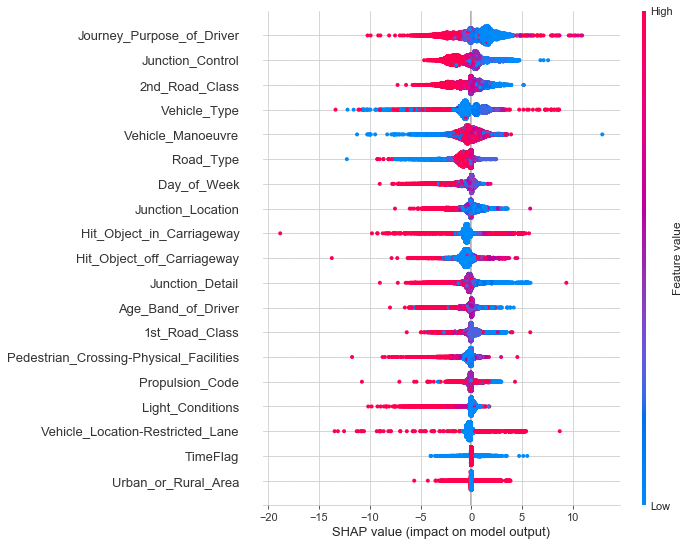

,Actual,Lower,Pred,upper,Flag,Interval
0,21,15,21,27,1,6
1,12,7,13,19,1,6
2,22,11,17,23,1,6
3,16,8,14,20,1,6
4,3,0,2,8,1,6
...,...,...,...,...,...,...
20992,14,7,13,19,1,6
20993,1,0,3,9,1,6
20994,4,0,6,12,1,6
20995,16,12,18,24,1,6


In [155]:
#Anaysis, treeBased=True for ELM
res=prediction_interval(sampleData, model, pi=.95, treeBased=False)
res.columns=['Actual','Lower', 'Pred', 'upper', 'Flag', 'Interval']
res

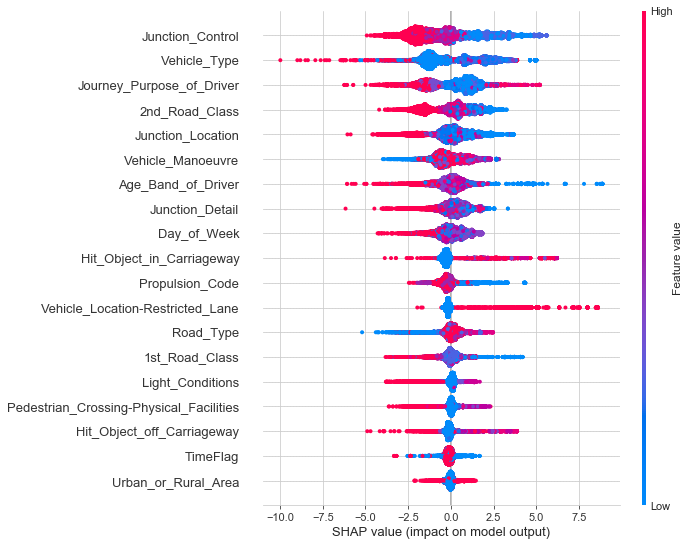

,Actual,Lower,Pred,upper,Flag,Interval
0,21,18,21,24,1,3
1,12,10,13,16,1,3
2,22,19,22,25,1,3
3,16,12,15,18,1,3
4,3,0,2,5,1,3
...,...,...,...,...,...,...
20992,14,10,13,16,1,3
20993,1,0,0,3,1,3
20994,4,0,4,7,1,3
20995,16,13,16,19,1,3


In [153]:
#Anaysis, treeBased=True for GBoost
resGboost=prediction_interval(sampleData, model2, pi=.95, treeBased=True)
resGboost.columns=['Actual','Lower', 'Pred', 'upper', 'Flag', 'Interval']
resGboost

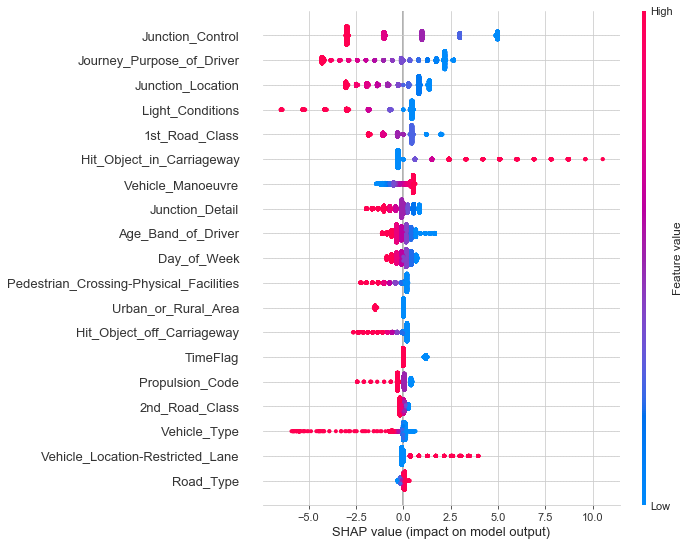

,Actual,Lower,Pred,upper,Flag,Interval
0,21,11,23,35,1,12
1,12,4,16,28,1,12
2,22,3,15,27,1,12
3,16,0,12,24,1,12
4,3,0,0,12,1,12
...,...,...,...,...,...,...
20992,14,10,22,34,1,12
20993,1,0,7,19,1,12
20994,4,0,10,22,1,12
20995,16,5,17,29,1,12


In [156]:
#Anaysis, treeBased=True for LinearSVR
resSVR=prediction_interval(sampleData, model3, pi=.95, treeBased=False)
resSVR.columns=['Actual','Lower', 'Pred', 'upper', 'Flag', 'Interval']
resSVR

## 6: Models' Prediction Analysis through the Prediction Interval

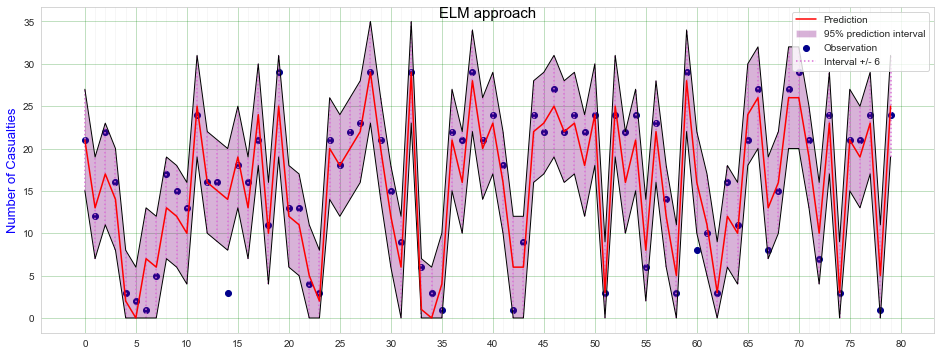

In [171]:
# Prediction Analysis on the ELM Model with 80 sample observations of the SampleData
top100=res.head(80)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(0,len(top100.Lower)), top100.Lower, linestyle = 'solid', linewidth=1, c='black')
plt.plot(range(0,len(top100.upper)), top100.upper, linestyle = 'solid', linewidth=1, c='black')
plt.fill(np.concatenate([range(0,len(top100.Lower)), range(0,len(top100.Lower))[::-1]]),
         np.concatenate([top100.upper, top100.Lower[::-1]]), alpha=.3, fc='purple', label='95% prediction interval')
plt.scatter(range(0,len(top100.Actual)), top100.Actual, label="Observation", c='darkblue')
#plt.scatter(range(0,len(top100.Pred)), top100.Pred, label="Predicted", c='green')
plt.plot(range(0,len(top100.Lower)), top100.Pred, c='r', label='Prediction')
plt.vlines(range(0,len(top100.Lower)), top100.Lower, top100.upper, colors='orchid', linestyles='dotted', 
           label='Interval +/- '+ str(top100.Interval.values[0]))
#plt.xlabel('Observation', color='#0A00ff')
plt.ylabel('Number of Casualties', color='#0A00ff', fontsize=13)
#plt.title('ELM approach', loc='left', fontsize=14)
#plt.xticks(range(0, len(top100.upper)+1, 5))
plt.legend( ncol=1, loc='upper right')
plt.grid(color='green', alpha=0.5, linestyle='solid')
major_ticks = np.arange(0, len(top100.upper)+1, 5)
minor_ticks = np.arange(0, len(top100.upper)+1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.3)
ax.text(0.5, 1, 'ELM approach',verticalalignment='top', horizontalalignment='center', 
        transform=ax.transAxes,color='black', fontsize=15)
plt.show()

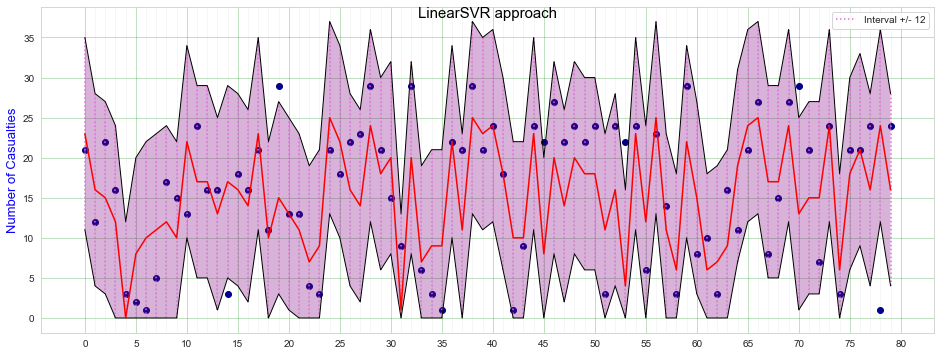

In [175]:
# Prediction Analysis on the LinearSVR Model with 80 sample observations of the SampleData
top100=resSVR.head(80)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(0,len(top100.Lower)), top100.Lower, linestyle = 'solid', linewidth=1, c='black')
plt.plot(range(0,len(top100.upper)), top100.upper, linestyle = 'solid', linewidth=1, c='black')
plt.fill(np.concatenate([range(0,len(top100.Lower)), range(0,len(top100.Lower))[::-1]]),
         np.concatenate([top100.upper, top100.Lower[::-1]]), alpha=.3, fc='purple')
plt.scatter(range(0,len(top100.Actual)), top100.Actual,  c='darkblue')
#plt.scatter(range(0,len(top100.Pred)), top100.Pred, label="Predicted", c='green')
plt.plot(range(0,len(top100.Lower)), top100.Pred, c='r')
plt.vlines(range(0,len(top100.Lower)), top100.Lower, top100.upper, colors='orchid', linestyles='dotted', 
           label='Interval +/- '+ str(top100.Interval.values[0]))
#plt.title('LinearSVR approach', loc='left', fontsize=14)
#plt.xlabel('Observation', color='#0A00ff')
plt.ylabel('Number of Casualties', color='#0A00ff', fontsize=13)
#plt.xticks(range(0, len(top100.upper)+1, 5), fontsize=12)
plt.legend(ncol=1, loc='best')

plt.grid(color='green', alpha=0.5, linestyle='solid')
major_ticks = np.arange(0, len(top100.upper)+1, 5)
minor_ticks = np.arange(0, len(top100.upper)+1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.3)
ax.text(0.5, 1, 'LinearSVR approach',verticalalignment='top', horizontalalignment='center', 
        transform=ax.transAxes,color='black', fontsize=15)
plt.show()

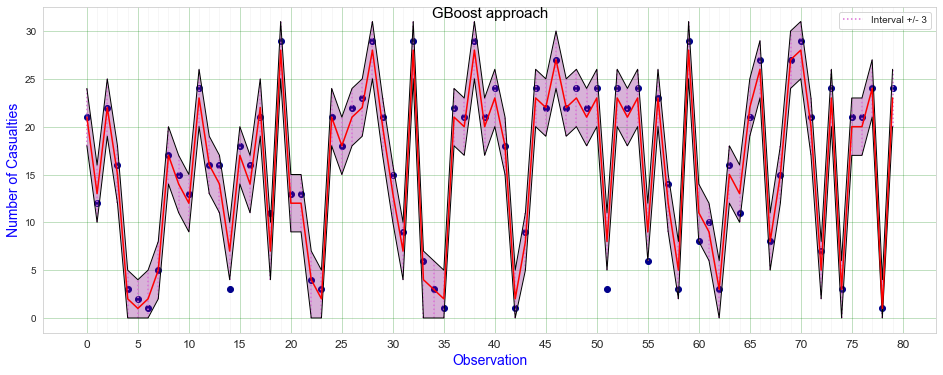

In [173]:
# Prediction Analysis on the GBoost Model with 80 sample observations of the SampleData
top100=resGboost.head(80)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(0,len(top100.Lower)), top100.Lower, linestyle = 'solid', linewidth=1, c='black')
plt.plot(range(0,len(top100.upper)), top100.upper, linestyle = 'solid', linewidth=1, c='black')
plt.fill(np.concatenate([range(0,len(top100.Lower)), range(0,len(top100.Lower))[::-1]]),
         np.concatenate([top100.upper, top100.Lower[::-1]]), alpha=.3, fc='purple')
plt.scatter(range(0,len(top100.Actual)), top100.Actual,  c='darkblue')
plt.vlines(range(0,len(top100.Lower)), top100.Lower, top100.upper, colors='orchid', linestyles='dotted', 
           label='Interval +/- ' + str(top100.Interval.values[0]))
#plt.scatter(range(0,len(top100.Pred)), top100.Pred, label="Predicted", c='green')
plt.plot(range(0,len(top100.Lower)), top100.Pred, c='r')
#plt.title('GBoost approach',fontsize=14, loc='left')
plt.xlabel('Observation', color='#0A00ff', fontsize=14)
plt.ylabel('Number of Casualties', color='#0A00ff', fontsize=14)
plt.xticks(range(0, len(top100.upper)+1, 5), fontsize=12)
plt.legend(ncol=1, loc='upper right')

plt.grid(color='green', alpha=0.5, linestyle='solid')
major_ticks = np.arange(0, len(top100.upper)+1, 5)
minor_ticks = np.arange(0, len(top100.upper)+1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.3)
ax.text(0.5, 1, 'GBoost approach',verticalalignment='top', horizontalalignment='center', 
        transform=ax.transAxes,color='black', fontsize=15)
plt.show()